In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
lena_measures = pd.read_csv(DATA_PATH / 'lena_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Compute age and retrieve group_id information
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)

aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
lena_measures = lena_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
    
aclew_measures = clean_pitch_concatenation(aclew_measures)
lena_measures = clean_pitch_concatenation(lena_measures)
human_measures = clean_pitch_concatenation(human_measures)

# Compute CVC
def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)

def compute_pitch_statistics(df):
    # Define a safe function to calculate statistics that handles empty arrays
    def safe_median(x):
        return np.nan if len(x) == 0 else np.median(x)
    
    def safe_percentile(x, q):
        return np.nan if len(x) == 0 else np.percentile(x, q)
    
    # Apply the safe functions to get initial values with NaNs for empty arrays
    df['median_pitch'] = df['pitch'].map(safe_median)
    df['first_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 25))
    df['third_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 75))
    
    # For each diagnostic group, calculate the mean of each pitch statistic
    group_means = df.groupby('group_id')[['median_pitch', 'first_quart_pitch', 'third_quart_pitch']].transform('mean')
    
    # Replace NaN values with their respective group means
    df['median_pitch'] = df['median_pitch'].fillna(group_means['median_pitch'])
    df['first_quart_pitch'] = df['first_quart_pitch'].fillna(group_means['first_quart_pitch'])
    df['third_quart_pitch'] = df['third_quart_pitch'].fillna(group_means['third_quart_pitch'])
    
    # In case any groups have all NaNs for a measure, fall back to the overall mean
    if df['median_pitch'].isna().any():
        overall_mean_median = df['median_pitch'].mean(skipna=True)
        df['median_pitch'] = df['median_pitch'].fillna(overall_mean_median)
        
    if df['first_quart_pitch'].isna().any():
        overall_mean_first_quart = df['first_quart_pitch'].mean(skipna=True)
        df['first_quart_pitch'] = df['first_quart_pitch'].fillna(overall_mean_first_quart)
        
    if df['third_quart_pitch'].isna().any():
        overall_mean_third_quart = df['third_quart_pitch'].mean(skipna=True)
        df['third_quart_pitch'] = df['third_quart_pitch'].fillna(overall_mean_third_quart)
    
    return df
columns = ['group_id', 'child_id', 
           'voc_chi',
           'voc_dur_chi',
           'CVC',
           'wc_adu',
           '5s_CTC',
           'median_pitch', 'first_quart_pitch', 'third_quart_pitch']
aclew_measures = compute_pitch_statistics(aclew_measures)[columns]
lena_measures = compute_pitch_statistics(lena_measures)[columns]
human_measures = compute_pitch_statistics(human_measures)[columns]

ACLEW - Best SVM parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.32 (239.0 correctly diagnosed)
LENA - Best SVM parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LENA acc = 0.33 (251.0 correctly diagnosed)
human - Best SVM parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.40 (298.0 correctly diagnosed)


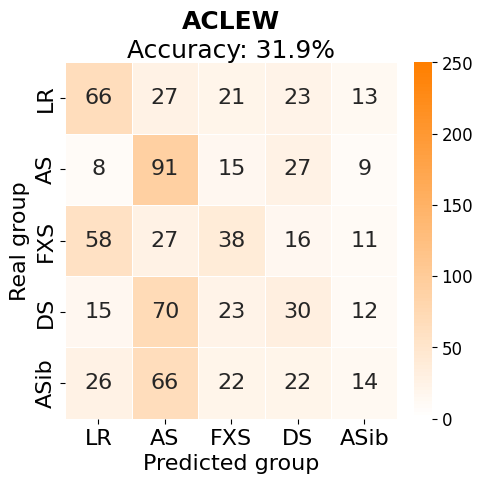

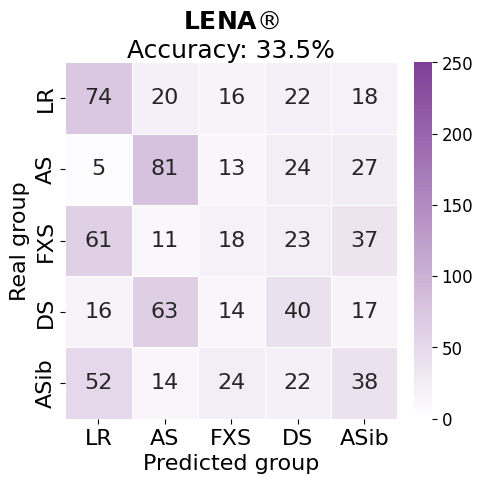

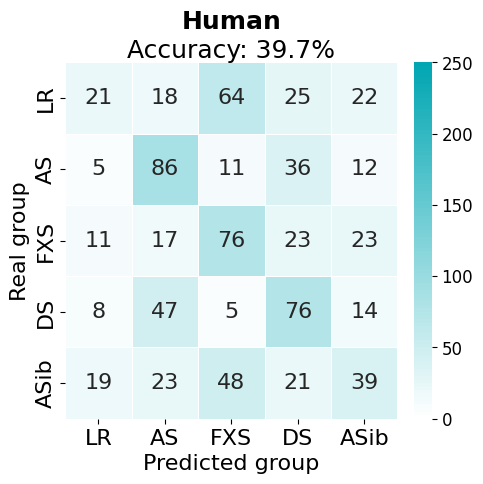


=== Summary of Results with Tuned SVM ===
ACLEW: acc = 0.32 (239.0 correctly diagnosed)
Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
LENA: acc = 0.33 (251.0 correctly diagnosed)
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human: acc = 0.40 (298.0 correctly diagnosed)
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Chance-level acc = 0.2 (10.0 correctly diagnosed)


In [18]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut, GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.base import clone
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.serif'] = 'Arial'
matplotlib.rcParams.update({'font.size': 16, 'legend.handleheight':1, 'hatch.linewidth': 1.0,
                           'lines.markersize':4, 'lines.linewidth':1, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
# Dictionary to store all results
results = {
    'ACLEW': {},
    'LENA': {},
    'human': {}
}

def evaluate_measures_with_tuned_svm(X, y, name, feature_names, group_classes=None, random_state=42):
    """
    Evaluates the dataset with a tuned SVM model
    
    Parameters:
        X: feature matrix
        y: target labels
        name: source of data ('ACLEW', 'LENA', or 'human')
        feature_names: names of the features
        group_classes: if 'three_groups', combine some labels
    """
    if group_classes == 'three_groups':
        # Create a copy to avoid modifying original labels
        y = y.copy()
        # Combine angelman, down, fragile_x into 'other'
        other_conditions = ['angelman_syndrome', 'down_syndrome', 'fragile_x_syndrome']
        y[np.isin(y, other_conditions)] = 'other'
    
    # First, let's use feature selection with Random Forest
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(
            C=0.1,  # Stronger regularization
            penalty='l2',
            solver='liblinear',
            class_weight='balanced',
            max_iter=1000
        ))
    ])
    
    # Define parameter grid for SVM
    param_grid = {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']  # liblinear works with both l1 and l2
    }
    
    # Use stratified k-fold for hyperparameter tuning
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    
    grid_search = GridSearchCV(
        pipeline, 
        param_grid=param_grid,
        cv=cv,
        scoring='accuracy',
        n_jobs=-1
    )
    
    # Fit grid search to find optimal parameters
    grid_search.fit(X, y)
    
    # Get best parameters
    best_params = grid_search.best_params_
    print(f"{name} - Best SVM parameters: {best_params}")
    
    # Create a new pipeline with best parameters
    best_pipeline = clone(pipeline)
    for param, value in best_params.items():
        component, param_name = param.split('__')
        setattr(best_pipeline.named_steps[component], param_name, value)
    
    # Evaluate with leave-one-out cross-validation
    loo = LeaveOneOut()
    
    predictions = []
    true_labels = []
    probabilities = []
    
    for train_idx, test_idx in loo.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # Fit the pipeline with best parameters
        best_pipeline.fit(X_train, y_train)
        
        # Make predictions
        pred = best_pipeline.predict(X_test)
        proba = best_pipeline.predict_proba(X_test)
        
        # Store results
        predictions.append(pred[0])
        true_labels.append(y_test[0])
        probabilities.append(proba[0])
    
    # Calculate accuracy and confusion matrix
    accuracy = accuracy_score(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=np.unique(y))
    
    # Store results
    results[name] = {
        'accuracy': accuracy,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities,
        'confusion_matrix': conf_matrix,
        'unique_labels': np.unique(y),
        'best_params': best_params
    }
    
    # Print accuracy
    num_correct = sum(p == t for p, t in zip(predictions, true_labels))
    print(f"{name} acc = {accuracy:.2f} ({num_correct:.1f} correctly diagnosed)")
    
    return results[name]

# Plot confusion matrices

def plot_confusion_matrix(results, method_name, color, title=None):
    """Plot confusion matrix for a specific method"""
    conf = results[method_name]['confusion_matrix']
    unique_labels = list(results[method_name]['unique_labels'])
    
    # Define orders and labels based on number of classes
    if len(unique_labels) == 5:  # five groups case
        order = ['low_risk', 'angelman_syndrome', 'fragile_x_syndrome', 'down_syndrome', 'autism_sibling']
        labels = ['LR', 'AS', 'FXS', 'DS', 'ASib']
    elif len(unique_labels) == 3:  # three groups case
        order = ['low_risk', 'autism_sibling', 'other']
        labels = ['LR', 'ASib', 'Neurogen']
    elif len(unique_labels) == 2:  # two groups case
        order = ['low_risk', 'other']
        labels = ['LR', 'AT']
    
    # Reorder the confusion matrix
    idx = [unique_labels.index(o) for o in order]
    conf = conf[idx][:, idx]
    
    # Calculate accuracy
    accuracy = np.sum(np.diag(conf)) / np.sum(conf) * 100
    
    # Create custom colormap
    colors = ['white', color]
    n_bins = 100
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("custom", colors, N=n_bins)
    
    cm = 1/2.54
    fig, ax = plt.subplots(1,1, figsize=(12*cm,12*cm), constrained_layout=True)
    
    sn.heatmap(conf, annot=True, ax=ax, fmt="d", linewidth=.5, 
               vmin=0, vmax=250, cmap=cmap)
    
    # Set title with accuracy
    if title is None:
        # Just accuracy, not in bold
        ax.set_title(f'Accuracy: {accuracy:.1f}%', fontsize=18)
    else:
        # Title in bold, accuracy not in bold
        title_obj = ax.set_title(f'{title}\nAccuracy: {accuracy:.1f}%', fontsize=18)
        
        # Split the title text to make only the first line bold
        title_text = title_obj.get_text().split('\n')
        if len(title_text) > 1:
            ax.set_title('')  # Clear the current title
            
            # Add the bold title
            ax.text(0.5, 1.08, title_text[0], transform=ax.transAxes, 
                   ha='center', va='bottom', fontsize=18, fontweight='bold')
            
            # Add the non-bold accuracy line
            ax.text(0.5, 1.00, title_text[1], transform=ax.transAxes, 
                   ha='center', va='bottom', fontsize=18)
        
    ax.set_yticklabels(labels, fontsize=16)
    ax.set_xticklabels(labels, fontsize=16)
    ax.set_ylabel('Real group', fontsize=16)
    ax.set_xlabel('Predicted group', fontsize=16)
    
    return fig

# Plot for each method with correct colors
colors = {
    'ACLEW': '#FF7F00',  # orange
    'LENA': '#7F3F98',   # purple
    'human': '#00A6B2'   # teal
}

titles = {
    'ACLEW': 'ACLEW',
    'LENA': r'LENA$\circledR$',
    'human': 'Human'
}

# Run analysis for each measurement source
for df, name in [(aclew_measures, 'ACLEW'), 
                 (lena_measures, 'LENA'), 
                 (human_measures, 'human')]:
    features = df.drop(['group_id', 'child_id'], axis=1)
    feature_names = features.columns
    X = features.values
    labels = df['group_id'].values
    
    results[name] = evaluate_measures_with_tuned_svm(X, labels, name, feature_names, group_classes=None)

for method, color in colors.items():
    fig = plot_confusion_matrix(results, method, color, title=titles[method])
    plt.savefig(f'/home/engaclew/neurogen/figures/diagnostic_classifiers/{method}_tuned_svm_classifier_30_min.png', dpi=300)
    plt.show()

# Print summary of results
print("\n=== Summary of Results with Tuned SVM ===")
for method in results:
    acc = results[method]['accuracy']
    num_correct = sum(p == t for p, t in zip(
        results[method]['predictions'], 
        results[method]['true_labels']
    ))
    best_params = results[method]['best_params']
    print(f"{method}: acc = {acc:.2f} ({num_correct:.1f} correctly diagnosed)")
    print(f"Best parameters: {best_params}")

print("\nChance-level acc = 0.2 (10.0 correctly diagnosed)")

In [19]:
# Now let's add canonical vs. non-canonical
from pathlib import Path
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil import relativedelta
from ChildProject.projects import ChildProject
from ChildProject.annotations import AnnotationManager
import ast

DATA_PATH = Path('/home/engaclew/neurogen')

# Read measures
aclew_measures = pd.read_csv(DATA_PATH / 'aclew_measures_chunks.csv').fillna(0)
human_measures = pd.read_csv(DATA_PATH / 'human_measures_chunks.csv').fillna(0)

# Compute age and retrieve group_id information
children = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/children.csv')
recordings = pd.read_csv(DATA_PATH / 'data/L3_HIPAA_LENA_cleaned/metadata/recordings.csv')
recordings_data = recordings.merge(children, on='child_id')[['group_id', 'date_iso', 'recording_filename', 'child_sex', 'child_dob']]
def diff_month(row):
    d1 = datetime.strptime(row['date_iso'], '%Y-%m-%d')
    d2 = datetime.strptime(row['child_dob'], '%Y-%m-%d')
    return (d1.year - d2.year) * 12 + d1.month - d2.month
recordings_data['age'] = recordings_data.apply(lambda row: diff_month(row), axis=1)

aclew_measures = aclew_measures.merge(recordings_data, how='left', on='recording_filename')
human_measures = human_measures.merge(recordings_data, how='left', on='recording_filename')

# Merge pitch from speech-like and non-speech-like vocalizatiojns
def clean_pitch_concatenation(df):
    def safe_eval(x):
        if pd.isna(x):
            return []
        try:
            return ast.literal_eval(x)
        except (ValueError, SyntaxError):
            return []
    df['speechlike_pitch'] = df['speechlike_pitch'].apply(safe_eval)
    df['nonspeechlike_pitch'] = df['nonspeechlike_pitch'].apply(safe_eval)
    df['pitch'] = df.apply( lambda row: row['speechlike_pitch'] + row['nonspeechlike_pitch'],  axis=1)
    return df
    
aclew_measures = clean_pitch_concatenation(aclew_measures)
human_measures = clean_pitch_concatenation(human_measures)

# Compute CVC
def compute_CVC(data):
    if 'can_voc_CHI' in data.columns and 'non_can_voc_CHI' in data.columns:
        data['CVC'] = data['can_voc_CHI'] + data['non_can_voc_CHI']
    return data

aclew_measures = compute_CVC(aclew_measures)
human_measures = compute_CVC(human_measures)

def compute_pitch_statistics(df):
    # Define a safe function to calculate statistics that handles empty arrays
    def safe_median(x):
        return np.nan if len(x) == 0 else np.median(x)
    
    def safe_percentile(x, q):
        return np.nan if len(x) == 0 else np.percentile(x, q)
    
    # Apply the safe functions to get initial values with NaNs for empty arrays
    df['median_pitch'] = df['pitch'].map(safe_median)
    df['first_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 25))
    df['third_quart_pitch'] = df['pitch'].map(lambda x: safe_percentile(x, 75))
    
    # For each diagnostic group, calculate the mean of each pitch statistic
    group_means = df.groupby('group_id')[['median_pitch', 'first_quart_pitch', 'third_quart_pitch']].transform('mean')
    
    # Replace NaN values with their respective group means
    df['median_pitch'] = df['median_pitch'].fillna(group_means['median_pitch'])
    df['first_quart_pitch'] = df['first_quart_pitch'].fillna(group_means['first_quart_pitch'])
    df['third_quart_pitch'] = df['third_quart_pitch'].fillna(group_means['third_quart_pitch'])
    
    # In case any groups have all NaNs for a measure, fall back to the overall mean
    if df['median_pitch'].isna().any():
        overall_mean_median = df['median_pitch'].mean(skipna=True)
        df['median_pitch'] = df['median_pitch'].fillna(overall_mean_median)
        
    if df['first_quart_pitch'].isna().any():
        overall_mean_first_quart = df['first_quart_pitch'].mean(skipna=True)
        df['first_quart_pitch'] = df['first_quart_pitch'].fillna(overall_mean_first_quart)
        
    if df['third_quart_pitch'].isna().any():
        overall_mean_third_quart = df['third_quart_pitch'].mean(skipna=True)
        df['third_quart_pitch'] = df['third_quart_pitch'].fillna(overall_mean_third_quart)
    
    return df
print(aclew_measures.columns)
columns = ['group_id', 'child_id', 
           'voc_chi',
           'voc_dur_chi',
           'CVC',
           'wc_adu',
           '5s_CTC',
           'can_voc_CHI',
           'can_voc_dur_CHI',
           'median_pitch', 'first_quart_pitch', 'third_quart_pitch']
aclew_measures = compute_pitch_statistics(aclew_measures)[columns]
human_measures = compute_pitch_statistics(human_measures)[columns]

Index(['recording_filename', 'segment_onset', 'segment_offset', 'child_id',
       'duration_alice', 'wc_fem', 'wc_mal', 'wc_adu', 'duration_vcm',
       'non_can_voc_CHI', 'can_voc_CHI', 'can_voc_dur_CHI', 'duration_vtc',
       'voc_dur_chi', 'voc_chi', 'avg_voc_dur_chi', '5s_CTC',
       'speechlike_pitch', 'nonspeechlike_pitch', 'group_id', 'date_iso',
       'child_sex', 'child_dob', 'age', 'pitch', 'CVC'],
      dtype='object')


(750, 10)
ACLEW - Best SVM parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
ACLEW acc = 0.31 (236.0 correctly diagnosed)
(750, 10)
human - Best SVM parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human acc = 0.40 (300.0 correctly diagnosed)


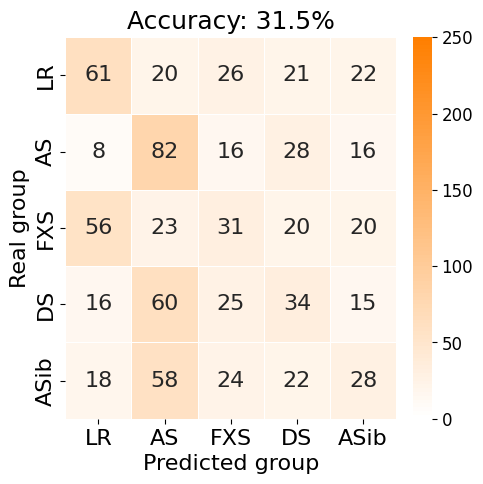

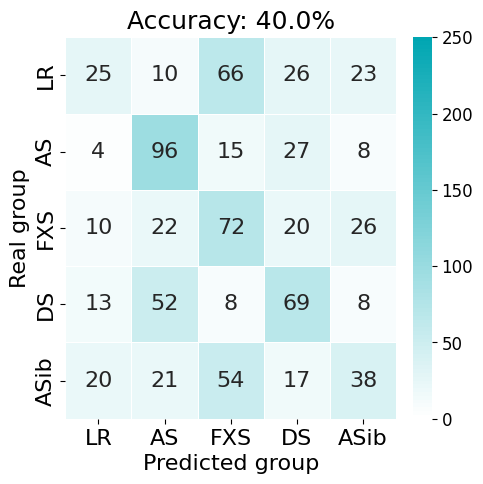


=== Summary of Results with Tuned SVM ===
ACLEW: acc = 0.31 (236.0 correctly diagnosed)
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
human: acc = 0.40 (300.0 correctly diagnosed)
Best parameters: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}

Chance-level acc = 0.2 (10.0 correctly diagnosed)


In [20]:
colors = {
    'ACLEW': '#FF7F00',  # orange
    'human': '#00A6B2'   # teal
}

# Run analysis for each measurement source
results = {}
for df, name in [(aclew_measures, 'ACLEW'), 
                 (human_measures, 'human')]:
    features = df.drop(['group_id', 'child_id'], axis=1)
    feature_names = features.columns
    X = features.values
    print(X.shape)
    labels = df['group_id'].values
    
    results[name] = evaluate_measures_with_tuned_svm(X, labels, name, feature_names, group_classes=None)

for method, color in colors.items():
    fig = plot_confusion_matrix(results, method, color)
    plt.savefig(f'/home/engaclew/neurogen/figures/diagnostic_classifiers/{method}_tuned_svm_classifier_2_min_with_canonical.png', dpi=300)
    plt.show()

# Print summary of results
print("\n=== Summary of Results with Tuned SVM ===")
for method in results:
    acc = results[method]['accuracy']
    num_correct = sum(p == t for p, t in zip(
        results[method]['predictions'], 
        results[method]['true_labels']
    ))
    best_params = results[method]['best_params']
    print(f"{method}: acc = {acc:.2f} ({num_correct:.1f} correctly diagnosed)")
    print(f"Best parameters: {best_params}")

print("\nChance-level acc = 0.2 (10.0 correctly diagnosed)")